In [1]:
import torch
import einops
import math

from dataclasses import dataclass

from utils.config import NetworkConfig, WorldConfig


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [42]:
@staticmethod
def beta_schedule(t: torch.Tensor, eps= 1e-4):
    beta = 0.5 - 0.5 * torch.cos(torch.pi * t)
    return beta

@staticmethod
def beta_dt(t: torch.Tensor):
    beta = 0.5 * torch.pi * torch.sin(torch.pi * t)
    return beta

@staticmethod
def cosine_schedule(t: torch.Tensor):
    return 1.0 - torch.cos(torch.pi * t * 0.5)

@staticmethod
def cosine_dt(t: torch.Tensor):
    return 0.5 * torch.pi * torch.sin(torch.pi * t * 0.5)

In [49]:
beta_dt(torch.tensor(1e-4))

tensor(0.0005)

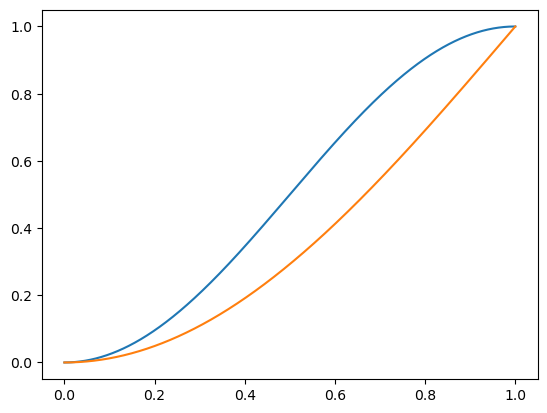

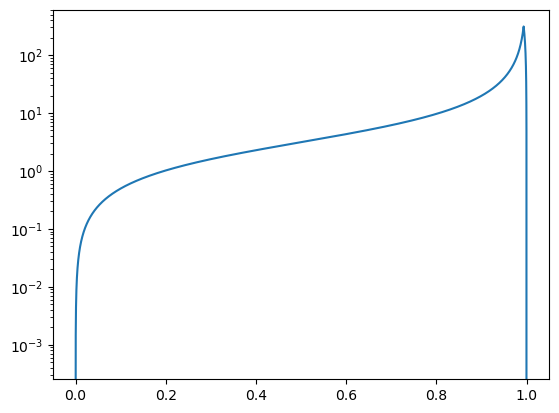

In [52]:
t = torch.linspace(0, 1, 10000)
plt.plot(t, beta_schedule(t))
plt.plot(t, cosine_schedule(t))
plt.show()
plt.plot(t, beta_dt(t) / (1 - beta_schedule(t)).clamp(1e-4))
plt.yscale('log')

In [27]:
import torch
eps = 5e-2

# Equation 1: 1 - cos(π/2 * t)
cosine_icdf = lambda t: 1 - torch.cos((torch.pi / 2) * t)
arcsin_icdf = lambda t: 0.5 - 0.5 * torch.cos(torch.pi * t)

# Equation 2: - (π/2) * tan(π/2 * t)
cosine_dt = lambda t: 0.5 * torch.pi * torch.tan((torch.pi / 2) * t.clamp(eps, 1-eps))
arcsin_dt = lambda t: torch.pi * torch.tan((torch.pi/ 2) * t.clamp(eps, 1-eps))

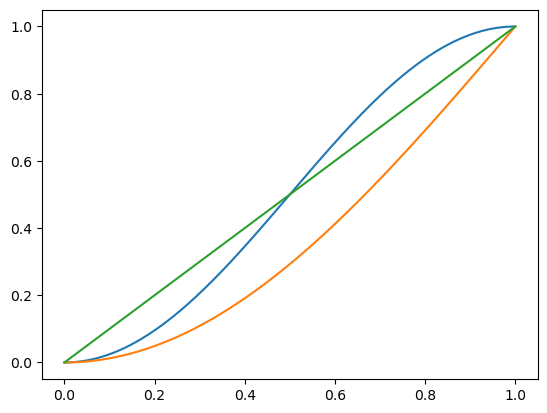

In [28]:
t = torch.linspace(0, 1, 1000)
arc_sch = arcsin_icdf(t)
cos_sch = cosine_icdf(t)
lin_sch = t
plt.plot(t, arc_sch)
plt.plot(t, cos_sch)
plt.plot(t, lin_sch)

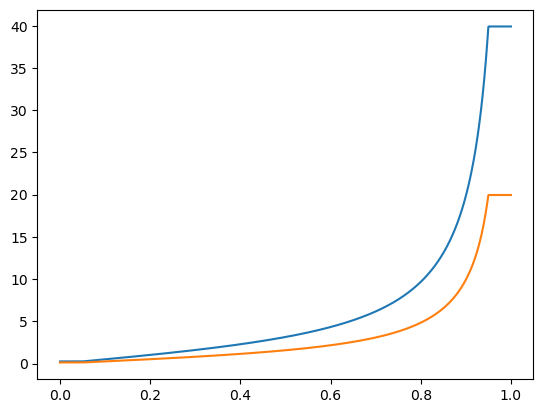

In [29]:
t = torch.linspace(0, 1, 1000)
plt.plot(t, arcsin_dt(t.clamp(eps, 1-eps)))
plt.plot(t, cosine_dt(t.clamp(eps, 1-eps)))
